# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

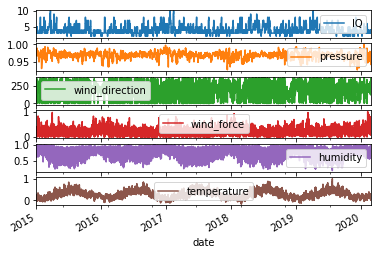

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,5.0,0.988013,0.126316,1.00,-0.007246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,5.0,0.986958,0.184211,0.95,-0.009662,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,5.0,0.987629,0.178947,0.94,-0.012077,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,5.0,0.987821,0.247368,0.85,0.028986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00+00:00,5.0,0.985999,0.336842,0.72,0.099034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
dummy = pd.get_dummies(features['wind_direction'])
windDummy = pd.DataFrame(columns = range(0,361,10))
windDummy[dummy.columns] = dummy.fillna(0)

features = pd.concat([features, windDummy], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 32 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)-1 # !!! To categorical, so the IQ is move from the range [1,10] to [0,9] 
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (1877, 32, 42)
y_train : (1877, 3, 1)


array([[[2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.]],

       ...,

       [[3.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [3.]]])

____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input, GRU, BatchNormalization, Dropout
from keras.models import save_model

In [9]:
OPTIMIZER = "Adam"
hiddenUnit = 512
denseSize = 512

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = GRU(hiddenUnit,input_shape=input_shape,name='GRUcommonLayer')(inp)
    _ = Dense(denseSize,name="intermediateDenseLayer")(_)
    _ = Dropout(0.3)(_)

    outD1 = Dense(10,name="D1", activation='softmax')(_)
    outD2 = Dense(10,name="D2", activation='softmax')(_)
    outD3 = Dense(10,name="D3", activation='softmax')(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'categorical_crossentropy', 'D2': 'categorical_crossentropy', 'D3': 'categorical_crossentropy'}, metrics={'D1': 'accuracy', 'D2': 'accuracy', 'D3': 'accuracy'})
    model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 42)       0                                            
__________________________________________________________________________________________________
GRUcommonLayer (GRU)            (None, 512)          852480      input_1[0][0]                    
__________________________________________________________________________________________________
intermediateDenseLayer (Dense)  (None, 512)          262656      GRUcommonLayer[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           intermediateDenseLayer

### Train

In [10]:
EPOCHS = 5
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board],verbose=2)
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

ValueError: Error when checking target: expected D1 to have shape (10,) but got array with shape (1,)

________________

### See the training in tensorboard

In [ ]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [ ]:
y_pred = model.predict(x_train)
y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

In [ ]:
np.array(y_train_visual).shape

Show the results in graphs:

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,7)

In [ ]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))

## Before exporting we need to shift the range of IQ from [0,9] to [1,10] !

In [ ]:
y_pred = y_pred+1